# Transfer Learning

### Aufgabe
_Wählen Sie nun 5 andere Hunderassen aus. Nutzen Sie Transfer Learning zur Klassifikation dieser
Rassen, d.h. laden Sie die Gewichte aus Ihrem in Teilaufgabe B5 trainierten Modell als initiale
Gewichte für das neue Training. Beschreiben Sie ihr Vorgehen im Kurzreport und setzen Sie die
Evaluation dieses erneuten Trainings in Relation zu den Evaluationsergebnissen ihres ursprünglichen
Modells._


---

> Aufbau ähnlich zu `deep_learning.ipynb`   
> Doppelte Schritte werden nicht erklärt und sind in dem Deep Learning Notebook genauer erläutert

Als Hunderassen wurden ähnliche Hunde wie bei dem initalien Training gewählt. Einzig und allein

In [ ]:
import keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from utils.setup import setup_dataset, generateDatasetArrays
from helper.visualize import visualize_history, visualize_predictions, getDognames

# load configuration
import config as Config

# config overrides
Config.DOG_LABEL_IDS = [0, 23, 107, 109, 88] # 5 andere Hunderassen

In [7]:
train_dataset, test_dataset, label_lookup_table, info = setup_dataset('../dataset', labels=Config.DOG_LABEL_IDS)

def preprocess(data):
    data["original_image"] = tf.identity(data["image"])
    data["image"] = tf.image.resize(data["image"], Config.RESIZE_SIZE)
    data["label"] = label_lookup_table.lookup(data["label"])
    return data

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .prefetch(tf.data.AUTOTUNE)
)

Total Image count:  500
Train Dataset Size: 375
Test Dataset Size: 125


---

Das trainierte Modell aus dem Deep Learning Teil wurde abgespeichert. Dieses wird nun wieder geladen und die letzten 3 Schichten werden entfernt (da die Schichten davor nur für die Feature Extraction sind).
Danach werden drei neue Schichten im selben Format wie die entfernten hinzugefügt. Diese Schichten werden mit den neuen Daten trainiert, um die Zuordnung der Features zu den Klassen neu festzulegen.

In [8]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))

model.pop()
model.pop()
model.pop()

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5, name="dense_dropout"))
model.add(keras.layers.Dense(Config.NUM_CLASSES, activation='softmax'))

# Freeze the layers except the last three
for layer in model.layers[:-3]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Finetuning**

ss

Finetuning des gesamten Modells
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Konfusionsmatrix:


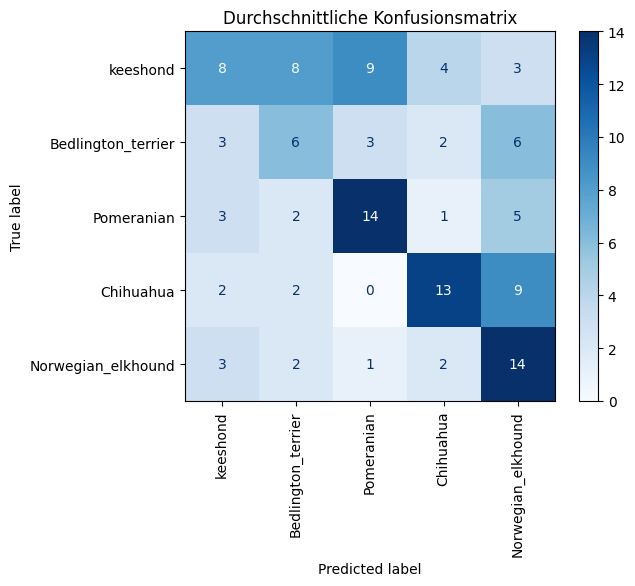

Test accuracy: 0.440


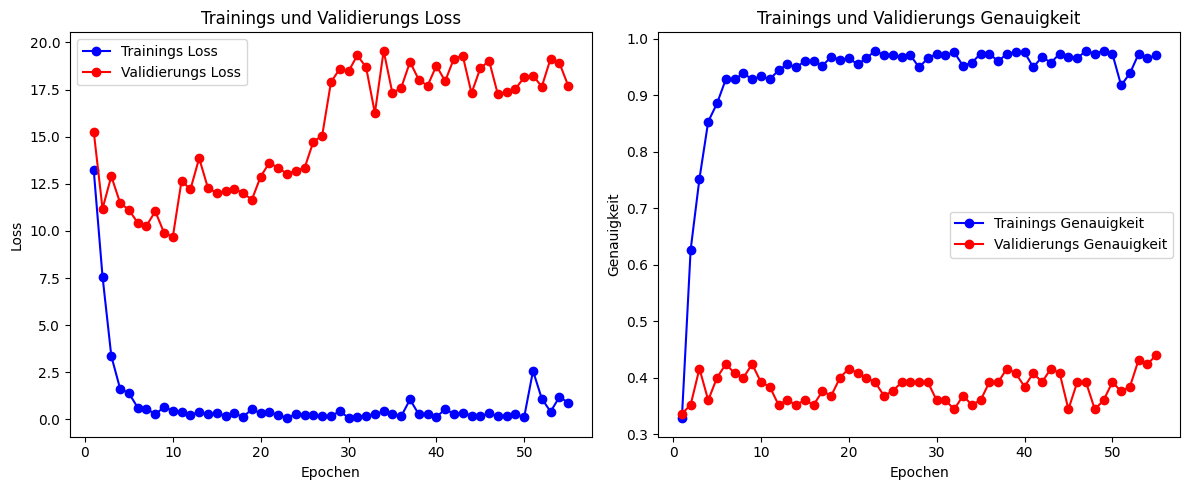

In [9]:
images, labels = generateDatasetArrays(train_dataset)
images_test, labels_test = generateDatasetArrays(test_dataset)

history = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=50,
    batch_size=Config.BATCH_SIZE,
    verbose=1 if Config.DEBUG else 0
)

# Feinabstimmung des gesamten Modells
for layer in model.layers:
    layer.trainable = True  # Alle Schichten freigeben

# Reduzierte Lernrate für Fine-Tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Finetuning des gesamten Modells")
history_finetune = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=5,
    batch_size=16,
    verbose=1 if Config.DEBUG else 0
)

# Evaluation
y_pred = model.predict(images_test)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(getDognames(train_dataset).values())

print("Konfusionsmatrix:")
# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_test, y_pred_classes), display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()

loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy: %.3f' % acc) 


for key in history.history.keys():
    history.history[key].extend(history_finetune.history[key])

visualize_history(history.history)

model.save(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))

# Evaluation Transfer Learning (Aufgabe 6)

Trotz dessen hat das neue Modell mit den neuen Hunderassen eine schlechtere Genauigkeit (0,68(neues Modell) zu 0,71(altes Modell)), dieser Unterschied wäre eigentlich noch stärker, da bei diesem Modell die ausgewählten Hunderassen ungefähr gleich viele Bilder haben (was ja bei Aufgabe 5 nicht der Fall war).

Der Grund warum dieses Modell trotzdem schlechter abschneidet ist vermutlich unter anderem, weil die Feature Exraction auf die Hunde des ersten Modells angepasst ist.

Test accuracy (Deep Learning): 0.168
Test accuracy (Transfer Learning): 0.440


2024-12-17 23:25:03.083606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


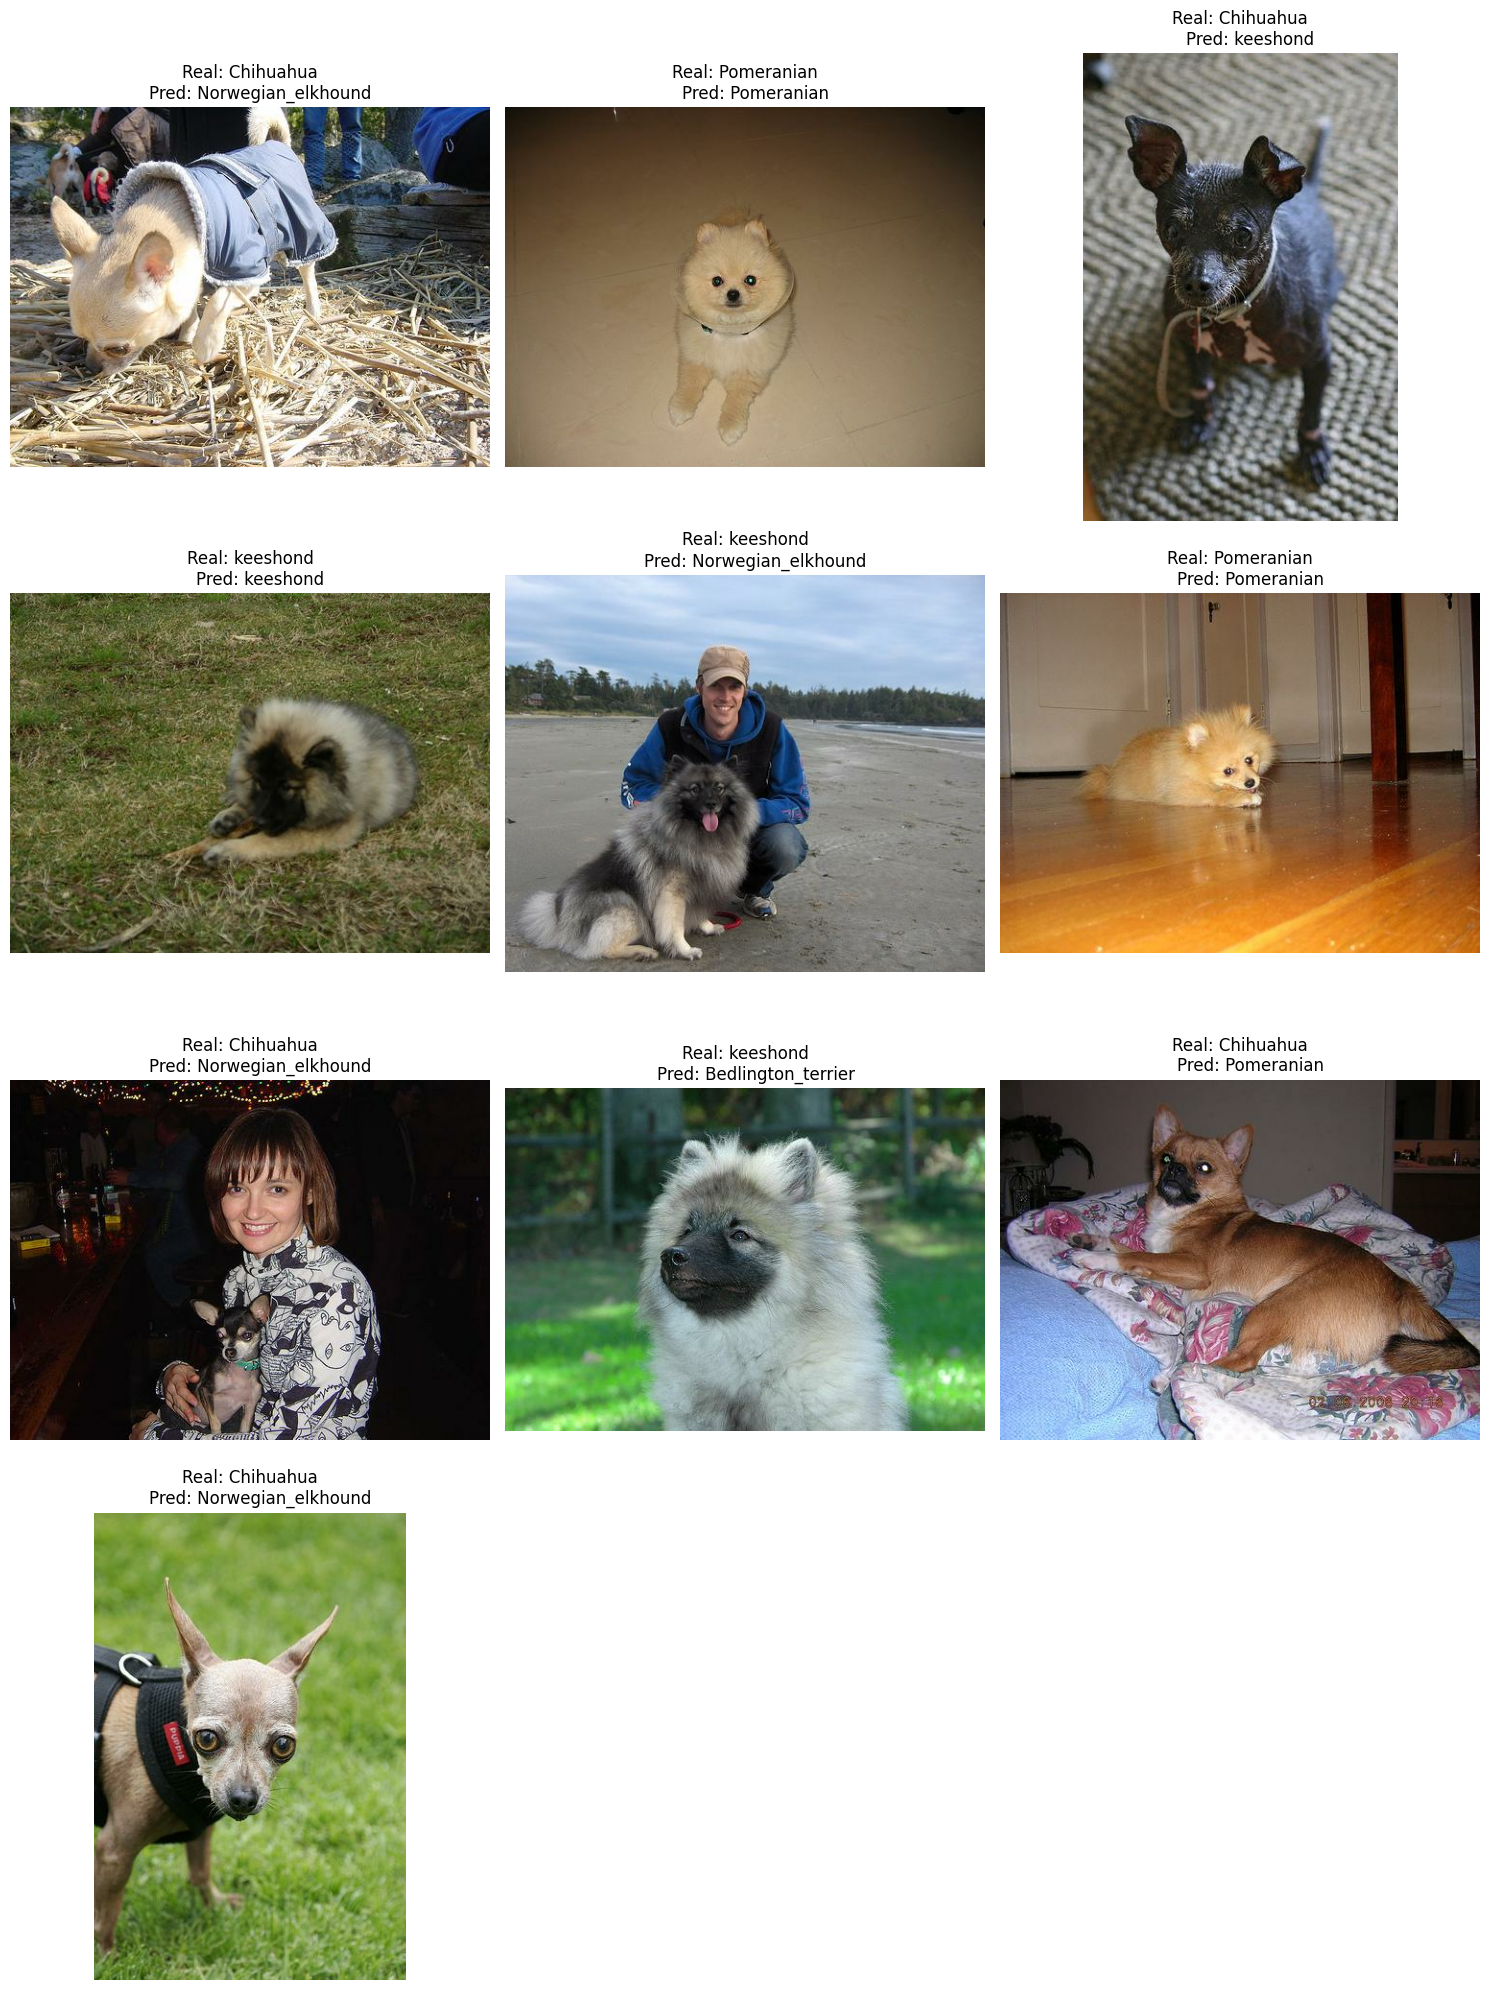

In [10]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy (Deep Learning): %.3f' % acc) 

model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy (Transfer Learning): %.3f' % acc) 

visualize_predictions(
    os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME),
    test_dataset
)